# Group Members:

*   Name 1 Albert Santos Moya 240690
*   Name 2 Elsa Ruiz Vargas 241545
*   Name 3 Héctor Naranjo Rodríguez 240498

# Lab 3 Assignment (Part 1)

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from math import sqrt
from IPython.display import clear_output, display

#### **1. Which of the following matrices are positive, semipositive or negative definite?**

In [43]:
# Define the matrixes
D1 = np.matrix([[-2, 0], [0, 4]])
D2 = np.matrix([[0, 0], [0, 2]])
D3 = np.matrix([[0.5, 0], [0, 1.5]])
A1 = np.matrix([[1, -3], [-3, 1]])
A2 = np.matrix([[1, -1], [-1, 1]])
A3 = np.matrix([[1, -.5], [-.5, 1]])

In [44]:
# TODO: Build up the code to demonstrate which matrices are
#       positive definite and reasoning what you are implementing
matrices = {"D1": D1, "D2": D2, "D3": D3, "A1": A1, "A2": A2, "A3": A3}

for key, matrix in matrices.items():
    eig_values = np.linalg.eigvals(matrix)
    if np.all(eig_values > 0):
        k = "Positive Definite"
    elif np.all(eig_values < 0):
        k = "Negative Definite"
    elif np.all(eig_values >= 0):
        k = "SemiPositive Definite"
    else:
        k = "Indefinite"
    print("{}: {} with eigen values = {}".format(key, k, eig_values))

D1: Indefinite with eigen values = [-2.  4.]
D2: SemiPositive Definite with eigen values = [0. 2.]
D3: Positive Definite with eigen values = [0.5 1.5]
A1: Indefinite with eigen values = [ 4. -2.]
A2: SemiPositive Definite with eigen values = [2. 0.]
A3: Positive Definite with eigen values = [1.5 0.5]


#### **2. The Python script quad_fun_main plots contours of the quadratic functions g<sub>i</sub>(x) =〈x, D<sub>i</sub>x〉and f<sub>i</sub>(x)  =〈x, A<sub>i</sub>x〉for  the  above  matrices.** 

- How  many  minima  does  each function have?  

  The only ones that have minimas are g<sub>3</sub> and F<sub>3</sub>. With one minima. 
  
  F1 and G1 have a saddle point and a similar situation happens for G<sub>2</sub> and F<sub>2</sub>.
  
  We know that because if the eigen values are both positive it has one minima and if it has a positive value only with a 0, it has a saddle point.

- Which is the relation between the g<sub>i</sub> and f<sub>i</sub>? 

  We observe that the matrices D<sub>i</sub> have the same eigenvalues as A<sub>i</sub> flipped and with opposite signs. Then, D<sub>i</sub> are the diagonal matrices of A<sub>i</sub>.


In [45]:
def quad_fun_main(matrixes: dict):
    # Define the x1 and x2 axis and mesh to draw the level lines
    x1 = np.arange(start = -10, stop = 10.1, step = 0.1)
    x2 = np.arange(start = -10, stop = 10.1, step = 0.1)
    X, Y = np.meshgrid(x1, x2)

    # Calculate Z
    x = np.matrix([X.T.flatten(), Y.T.flatten()])
    results = {}
    for key, matrix in matrixes.items():
        print("Procesing {}".format(key))
        aux = np.matmul(matrix, x)
        result = np.zeros((x1.shape[0], x2.shape[0]))
        for j in range(result.shape[0]):
            for i in range(result.shape[1]):
                result[i, j] = (x[:, result.shape[0] * j + i].T * aux[:, result.shape[0] * j + i])
        if key.startswith("D"):
            matrix_name = "G{}".format(key[-1])
        else:
            matrix_name = "F{}".format(key[-1])
        print("\tSaving as {}".format(matrix_name))
        results[matrix_name] = result

    # Plot the contours
    fig, axs = plt.subplots(nrows = int(len(results) / 3), 
                        ncols = 3, 
                        figsize = (14,8))
    for row in range(axs.shape[0]):
        for column in range(axs.shape[1]):
            matrix_name = list(results.keys())[axs.shape[0] * row + row + column]
            Z = results.get(matrix_name)
            axs[row, column].contour(X, Y, Z, 
                                     corner_mask = False, levels = 150, 
                                     linewidths=(1,), cmap = cm.coolwarm)
            axs[row, column].set_title(matrix_name)    
        
    # Plot the surfaces
    fig = plt.figure(figsize=(16, 10))
    for row in range(axs.shape[0]):
        for column in range(axs.shape[1]):
            ax = fig.add_subplot(axs.shape[0], axs.shape[1], axs.shape[0] * row + row + column + 1, projection='3d')
            matrix_name = list(results.keys())[axs.shape[0] * row + row + column]
            Z = results.get(matrix_name)
            ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False)
            ax.set_title(matrix_name)    

Procesing D1
	Saving as G1
Procesing D2
	Saving as G2
Procesing D3
	Saving as G3
Procesing A1
	Saving as F1
Procesing A2
	Saving as F2
Procesing A3
	Saving as F3


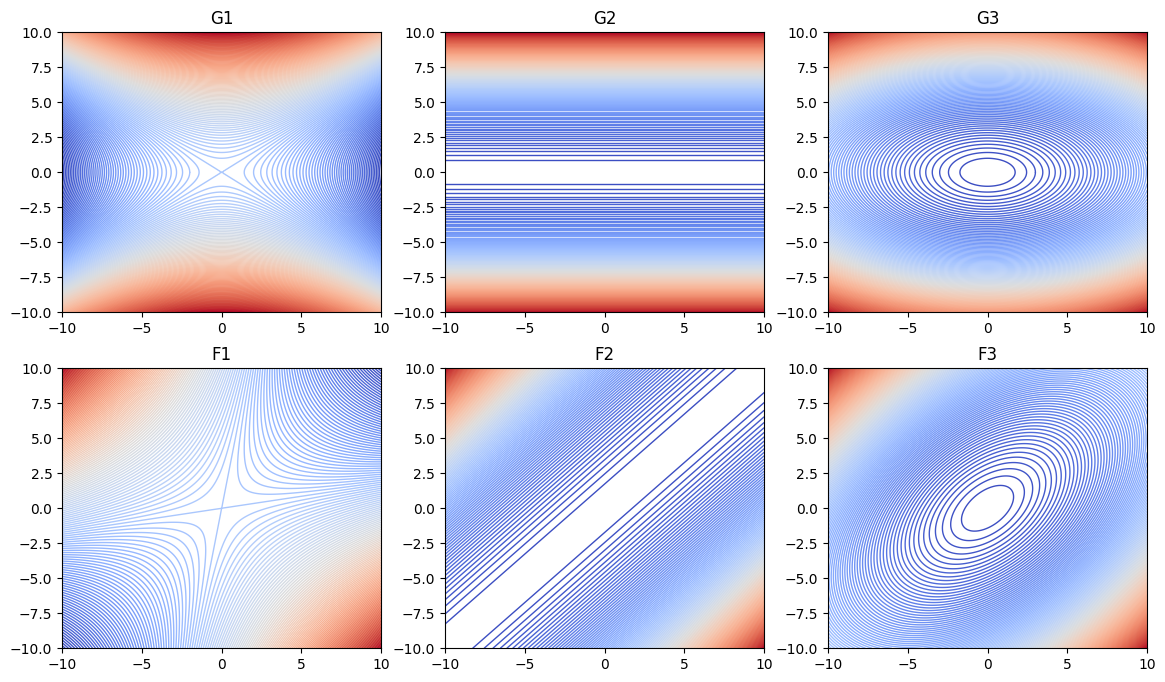

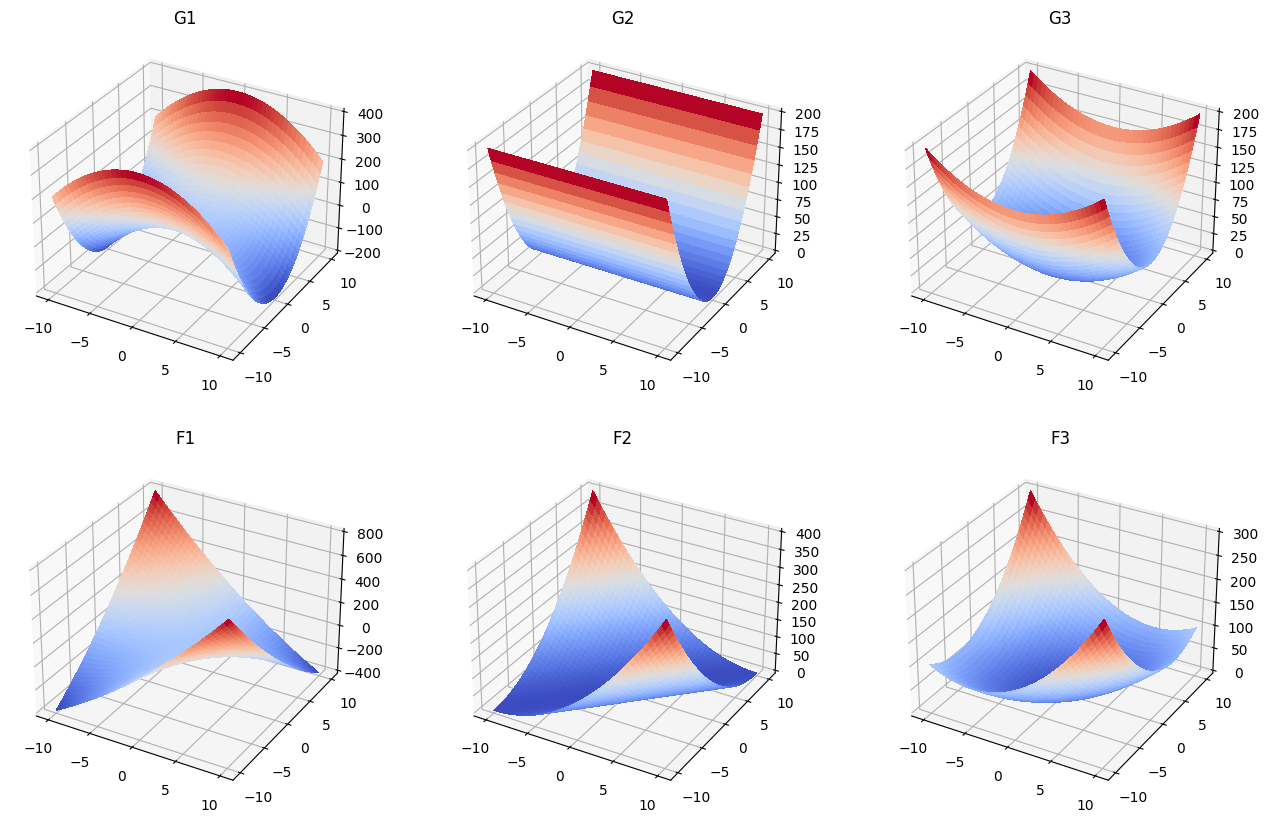

In [46]:
# Define the matrixes dictionary
matrixes = {"D1": D1, "D2": D2, "D3": D3, "A1": A1, "A2": A2, "A3": A3}

# Run the quad_fun_main
quad_fun_main(matrixes)

#### **3. Complete the code of the Python function grad_descent().Follow the comments in the code.**

In [47]:
def multiply_ax(x):
    return A * x

In [48]:
def gradient_descent(callback,
                     b: np.matrix,
                     callback_params: dict,
                     initial_condition: np.matrix,
                     max_iters: int,
                     tolerance: float,
                     fig = None,
                     ax = None):
    """
    Implementation of the gradient descent algorithm (a
    gradient descent scheme with optimal adaptive step size) for the minimization
    of quadratic problems 

       f(x) = 1/2 x'Ax - bx. 

    It uses function handles. It requires a handle to a Python function that implements the product of matrix A with x.

    :param callback: handle (pointer) to a Python function implementing the product with matrix A.
    :param b: vector b, can be in matrix form (MxN)
    :param callback_params: a dictionary with the callback function params
    :param x0: initial condition, same dimensions as b (MxN)
    :param max_iters: maximum number of iterations
    :param tolerance: tolerance for the stopping condition (it stop when the norm of the gradient is below the tolerance)

    :return x: value found (MxN)
    :return fs: evolution of the target function (total_iters x 1 vector)
    """
    Ax = callback(initial_condition, **callback_params)
    r = Ax - b                        # TODO: compute residual (the gradient)
    nr = np.multiply(r,r).sum()      # TODO: inner product of gradient
    
    # Note: since the variables can be stored as matrices (for example, x is an image)
    #       we use np.multiply(x1, x2) to compute the dot products.

    # Allocate memory for vector of energy values of the iterates
    fs  = []
    current_value = initial_condition

    # Start loop 
    it = 0

    while (sqrt(nr) > tolerance) and (it < max_iters):
        # Increase iteration counter
        it = it + 1
        print("[{} of {}]\t-> |grad f(x)| = {}".format(it, max_iters, nr))

        # TODO: Compute quadratic energy f = .5 <Ax - b,x> - 0.5* <b,x>
        value = (0.5*np.multiply(r,current_value).sum()) - (0.5*np.multiply(b,current_value).sum())
        fs.append(value)

        # 1. line search in r - compute time step alpha
        Ar = callback(r, **callback_params)
        alpha = nr / (np.multiply(r,Ar).sum())

        previous_value = current_value # keep x_old - just for visualization

        #2. TODO: update point x
        current_value = current_value - (alpha * r)

        # TODO: compute new residual r = Ax - b
        Ax = callback(current_value, **callback_params)
        r = Ax - b                        # TODO: compute residual (the gradient)
        nr = np.multiply(r,r).sum()        # TODO: inner product of gradient
    
        # ----- plot current position! Just for visualization purposes -----
        if current_value.shape == (2, 1):
            if not ax:
                fig, ax = plt.subplots()
            ax.plot(current_value[0, 0], current_value[1, 0], marker = 'o', color = "k")
            ax.plot([previous_value[0, 0], current_value[0, 0]], 
                    [previous_value[1, 0], current_value[1, 0]], "-k")
            clear_output(wait=True)
            display(fig) 
        elif current_value.shape[0] > 1 and current_value.shape[1] > 1:
            # if x is a matrix (an image) (visualization of denoising) 
            if it % 10 == 0 or it == 1:
                if not ax:
                    fig, ax = plt.subplots(figsize = (12, 8))
                ax.imshow(current_value, cmap = "gray")
                clear_output(wait=True)
                display(fig) 
    
    print("[{} of {}]\t-> |grad f(x)| = {}".format(it, max_iters, nr))
    return current_value, np.matrix(fs).T

#### **4. Complete the code of the Python function conj_grad. Follow the comments in the code**

In [49]:
def conjugate_gradient(callback,
                       b: np.matrix,
                       callback_params: dict,
                       initial_condition: np.matrix,
                       tolerance: float,
                       max_iters: int,
                       fig = None,
                       ax = None):
    """
    implementation of the conjugate gradient algorithm for the minimization of quadratic problems 

       f(x) = 1/2 x'Ax - bx. 

    It uses function handles. It requires a handle to a Python function that implements the product of matrix A with x.

    :param callback: handle (pointer) to a Python function implementing the product with matrix A. 
    :param callback_params: dictionary containing the params for the callback functions
    :param b: vector b, can be in matrix form (MxN)
    :param initial_conditions: initial condition, same dimensions as b (MxN)
    :param max_iters: maximum number of iterations
    :param tolerance: tolerance for the stopping condition (it stop when the norm of the gradient is below the tolerance)

    :return x: value found (MxN)
    :return fs: evolution of the target function (total_iters x 1 vector)
    """

    Ax = callback(initial_condition, **callback_params)
    r = Ax - b                        # TODO: compute residual (the gradient)
    nr = np.multiply(r,r).sum()                # TODO: inner product of gradient
    d = -r.copy()                       # TODO: first descent direction is the negative grad.
    
    # Note: since the variables can be stored as matrices (for example, x is an image)
    #       we use np.multiply(x1, x2) to compute the dot products.

    # Allocate memory for vector of energy values of the iterates
    fs  = []
    current_value = initial_condition

    # Start loop 
    it = 0

    while (sqrt(nr) > tolerance) and (it < max_iters):
        # Increase iteration counter
        it = it + 1
        if it % 10 == 0:
            print("[{} of {}]\t-> |grad f(x)| = {}".format(it, max_iters, nr))

        # Compute quadratic energy f = .5 <Ax - b,x> - 0.5* <b,x>
        fs.append(0.5 * np.multiply(r, current_value).sum() - 0.5 * np.multiply(b, current_value).sum())

        # 1. TODO: line search in d - compute time step alpha
        Ad = callback(d, **callback_params)
        alpha = np.multiply(d,r).sum()/np.multiply(d,Ad).sum()

        previous_value = current_value # keep x_old - just for visualization

        #2. TODO: update point x
        current_value = current_value - (alpha*d)

        # compute new residual r = Ax - b
        Ax = callback(current_value, **callback_params)
        r = Ax - b                          # TODO: compute residual (the gradient)
        nr_old = nr                       # inner product of the old residual
        nr = np.multiply(r,r).sum()         # TODO: squared norm of gradient

        # A-orthogonalization of r (Gram-Schmidt)
        # new search direction d is a linear combination of r and previous d
        # chosen so that it is A-orthogonal with the previous search directions
        beta_2 = nr/nr_old
        d = -r.copy() + beta_2*d
        
        # ----- plot current position! Just for visualization purposes -----
        if current_value.shape == (2, 1):
            if not ax:
                fig, ax = plt.subplots()
            ax.plot(current_value[0, 0], current_value[1, 0], marker = 'o', color = "r")
            ax.plot([previous_value[0, 0], current_value[0, 0]], 
                    [previous_value[1, 0], current_value[1, 0]], "-r")
            clear_output(wait=True)
            display(fig) 
        elif current_value.shape[0] > 1 and current_value.shape[1] > 1:
            # if x is a matrix (an image) (visualization of denoising) 
            if it % 10 == 0:
                if not ax:
                    fig, ax = plt.subplots(figsize = (12, 8))
                ax.imshow(current_value, cmap = "gray")
                clear_output(wait=True)
                display(fig) 
                
    print("[{} of {}]\t-> |grad f(x)| = {}".format(it, max_iters, nr))
    return current_value, np.matrix(fs).T

#### **5. Run the functions conj_grad_test_i with i = 1, 2, 3.These script computes the minima of quadratic functions in R2 and R100. Complete the code if needed and answerthe questions in the code.**

In [50]:
A = None

**conj_grad_test_1**

In [51]:
def conj_grad_test_1():
    global A
    # We start by visualizing a problem in IR^2, and comparing the gradient descent with the conjugate gradient

    # --------------------------------------------------------------------------------------
    # create grid to plot contours of quadratic function -----------------------------------
    # --------------------------------------------------------------------------------------
    x1 = np.arange(start = -10, stop = 10.1, step = 0.1)
    x2 = np.arange(start = -10, stop = 10.1, step = 0.1)
    X, Y = np.meshgrid(x1, x2)

    # matrix containing all grid points as columns
    x = np.matrix([X.T.flatten(), Y.T.flatten()])

    # --------------------------------------------------------------------------------------
    # start with a trivial example: a quadratic function based on the identity matrix ------
    # --------------------------------------------------------------------------------------
    A = np.matrix([[1, 0], [0, 1]])
    b = np.matrix([[4], [3]])

    # evaluate function for all points in x
    Ax = A * x
    bx = b.T * x

    result = np.zeros((x1.shape[0], x2.shape[0]))
    for j in range(result.shape[0]):
        for i in range(result.shape[1]):
            result[i, j] = 0.5 * x[:, result.shape[0] * j + i].T * Ax[:, result.shape[0] * j + i] - bx[:, result.shape[0] * j + i]

    # Plot the contour of f
    fig = plt.figure()
    plt.contour(X, Y, result, 
                corner_mask = False, levels = 150, 
                linewidths=(1,), cmap = cm.coolwarm)
    plt.title('Level lines of f(x) = 1/2 x^T I x - bx')

    # run gradient descent 
    tolerance = 1e-5
    max_iters = 1000
    x1 = gradient_descent(callback = multiply_ax,
                          b = b, 
                          callback_params = {},  
                          initial_condition = np.matrix([[-7.5], [-7.5]]),  # TRY several starting points
                          tolerance = tolerance,
                          max_iters = max_iters, 
                          fig = fig,
                          ax = plt.gca())

    # How many iterations does the gradient descent need to converge? Why?
    # -> It will need one iteration to converge. This is because we are working with the Identity Matrix.
    #    Then, it makes sense that the gradient descent converges in a unique iteration.
    # How many iterations would the conjugate gradient need to converge? Why?
    # -> We're going to need only one more, because we are working with the Identity Matrix.

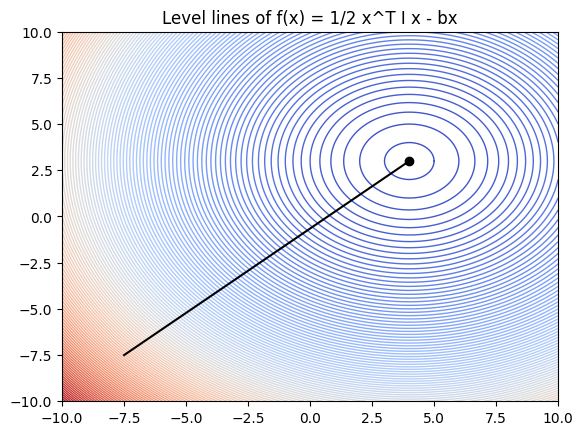

[1 of 1000]	-> |grad f(x)| = 0.0


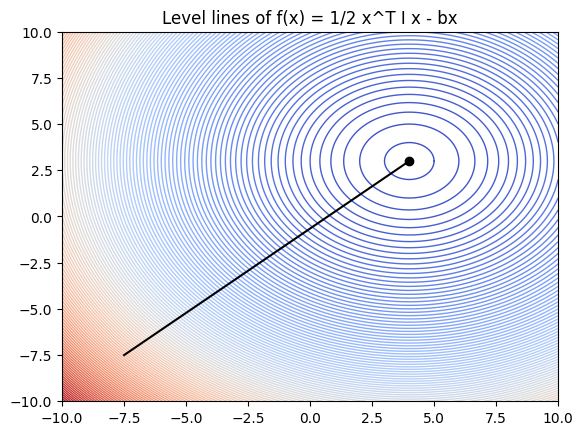

In [52]:
conj_grad_test_1()

**conj_grad_test_2**

In [53]:
def conj_grad_test_2():
    global A
    # We start by visualizing a problem in IR^2, and comparing the gradient descent with the conjugate gradient

    # --------------------------------------------------------------------------------------
    # create grid to plot contours of quadratic function -----------------------------------
    # --------------------------------------------------------------------------------------
    x1 = np.arange(start = -10, stop = 10.1, step = 0.1)
    x2 = np.arange(start = -10, stop = 10.1, step = 0.1)
    X, Y = np.meshgrid(x1, x2)

    # matrix containing all grid points as columns
    x = np.matrix([X.T.flatten(), Y.T.flatten()])

    # --------------------------------------------------------------------------------------
    # a more general quadratic function ----------------------------------------------------
    # --------------------------------------------------------------------------------------
    A = np.matrix([[1, .9], [.9, 1]])
    b = np.matrix([[1], [2]])

    # evaluate function for all points in x
    Ax = A * x
    bx = b.T * x

    result = np.zeros((x1.shape[0], x2.shape[0]))
    for j in range(result.shape[0]):
        for i in range(result.shape[1]):
            result[i, j] = 0.5 * x[:, result.shape[0] * j + i].T * Ax[:, result.shape[0] * j + i] - bx[:, result.shape[0] * j + i]

    # Plot the contour of f
    fig = plt.figure()
    ax = plt.gca()
    plt.contour(X, Y, result, 
                corner_mask = False, levels = 150, 
                linewidths=(1,), cmap = cm.coolwarm)
    plt.title('Level lines of f(x) = 1/2 x^T I x - bx')

    # run gradient descent 
    tolerance = 0.00001
    max_iters = 1000
    x1 = gradient_descent(callback = multiply_ax,
                          b = b, 
                          callback_params = {},  
                          initial_condition = np.matrix([[5], [-5]]),  # TRY several starting points
                          tolerance = tolerance,
                          max_iters = max_iters, 
                          fig = fig,
                          ax = ax)

    # run gradient descent 
    tolerance = 0.00001
    max_iters = 100
    x1 = conjugate_gradient(callback = multiply_ax,
                            b = b, 
                            callback_params = {},  
                            initial_condition = np.matrix([[5], [-5]]),  # TRY several starting points
                            tolerance = tolerance,
                            max_iters = max_iters, 
                            fig = fig,
                            ax = ax)

    # How many iterations does the gradient descent need to converge?
    # -> Checking the function gradient_descent(), we can see that it needs 101 iterations.
    # Does the performance of the gradient descent depend on the position of the initial condition? 
    # -> Yes, the result will be different due to each point will have a different output.
    # Are there any initial conditions for which the gradient descent converges in one iteration?
    # -> When the initial point is near to the minima.
    # Which is the angle between consecutive descent directions for the gradient descent? Why?
    # -> It's 90 degrees because from theory we know that they are orthogonal. This happens because optimal step length 
    #    is given when the search direction is tangent to a level line.
    # How many iterations would the conjugate gradient need to converge? Why?
    # -> At most it will need 2 iterations because it's the dimension of the matrix A (2x2) and we know that the conjugate gradient
    #    converges at most at n.

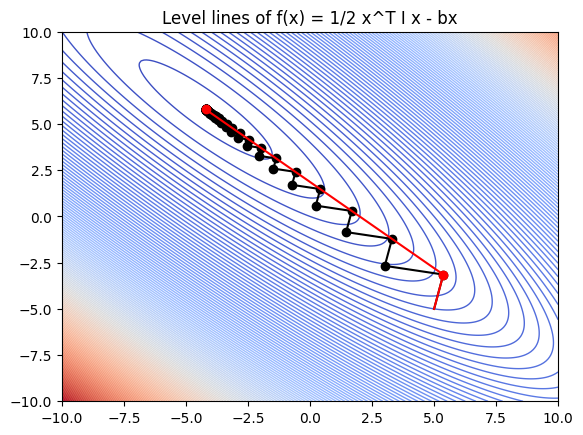

[2 of 100]	-> |grad f(x)| = 1.5432091458386043e-29


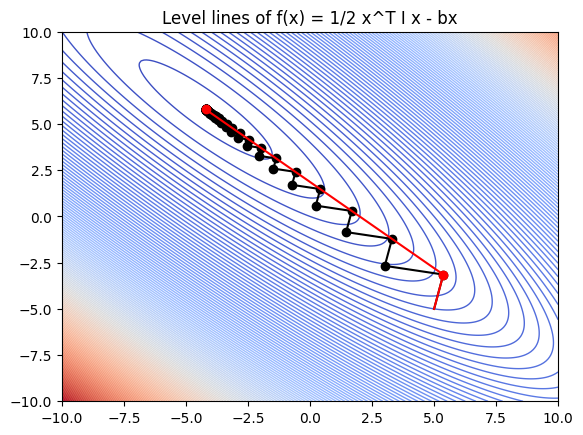

In [ ]:
conj_grad_test_2()

In [40]:
def conj_grad_test_3():
    global A
    # Now we compare the gradient descent and the conjugate gradient for a problem in IR^100. 

    # Define the problem matrix. Is it symmetric? Is it positive definite?
    A = np.matrix(np.ones(shape = (100, 100)) + np.diag(np.arange(0, 100)))
    b = np.matrix(np.ones(shape = (100, 1)))

    # run gradient descent 
    tolerance = 10 ** -5
    max_iters = 10 ** 6
    x1, fs_1 = gradient_descent(callback = multiply_ax,
                          b = b, 
                          callback_params = {},  
                          initial_condition = np.zeros_like(b),  # TRY several starting points
                          tolerance = tolerance,
                          max_iters = max_iters)

    # run gradient descent 
    tolerance = 10 ** -5
    max_iters = 100
    x2, fs_2 = conjugate_gradient(callback = multiply_ax,
                            b = b, 
                            callback_params = {},  
                            initial_condition = np.zeros_like(b),  # TRY several starting points
                            tolerance = tolerance,
                            max_iters = max_iters)

    m = -0.5 * b.T * np.linalg.lstsq(A, b)[0]
    m = m[0,0]

    fig, ax = plt.subplots(figsize = (14, 8))
    ax.semilogy(fs_1 - m)
    ax.semilogy(fs_2 - m, 'r') 
    ax.legend(['gradient descent', 'conjugate gradient'])
    ax.set_title('logarithmic plot of f(x_i) - f^*')

    # Which one converges faster?
    # -> From the results we can see from the graph, is the conjugate gradient, moreover, as we said before, it will converge in N iterations.
    # Which is the order of convergence of the gradient descent?
    # -> The order of convergence of the gradient descent method is one, it means that the error decreases linearly with each iteration.
    # Why is the logarithmic plot of the error for the gradient descent linear?
    # -> As we said before, it's following a linear model. Then, we can see that the plot is following a linear tendency.
    # Which is the maximum number of iterations needed for the conjugate gradient?
    # -> In at most 100 iterations, as we said before, the conjugate gradient converges in at most N iterations.

[1 of 1000000]	-> |grad f(x)| = 100.0
[2 of 1000000]	-> |grad f(x)| = 3.7281462176038276
[3 of 1000000]	-> |grad f(x)| = 2.28177307426979
[4 of 1000000]	-> |grad f(x)| = 0.8793913050693438
[5 of 1000000]	-> |grad f(x)| = 0.9567206536855937
[6 of 1000000]	-> |grad f(x)| = 0.5080692459887963
[7 of 1000000]	-> |grad f(x)| = 0.6174591613824172
[8 of 1000000]	-> |grad f(x)| = 0.3477295782300828
[9 of 1000000]	-> |grad f(x)| = 0.44690729354241876
[10 of 1000000]	-> |grad f(x)| = 0.2607313022562153
[11 of 1000000]	-> |grad f(x)| = 0.3471701152395319
[12 of 1000000]	-> |grad f(x)| = 0.20731827789428744
[13 of 1000000]	-> |grad f(x)| = 0.2827853803058591
[14 of 1000000]	-> |grad f(x)| = 0.1716585992182595
[15 of 1000000]	-> |grad f(x)| = 0.2382460787922295
[16 of 1000000]	-> |grad f(x)| = 0.14637990894394984
[17 of 1000000]	-> |grad f(x)| = 0.20582991956637237
[18 of 1000000]	-> |grad f(x)| = 0.12763814125790185
[19 of 1000000]	-> |grad f(x)| = 0.1813044840443902
[20 of 1000000]	-> |grad f(x)| 

<ipython-input-55-575f8a5a3668>:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m = -0.5 * b.T * np.linalg.lstsq(A, b)[0]


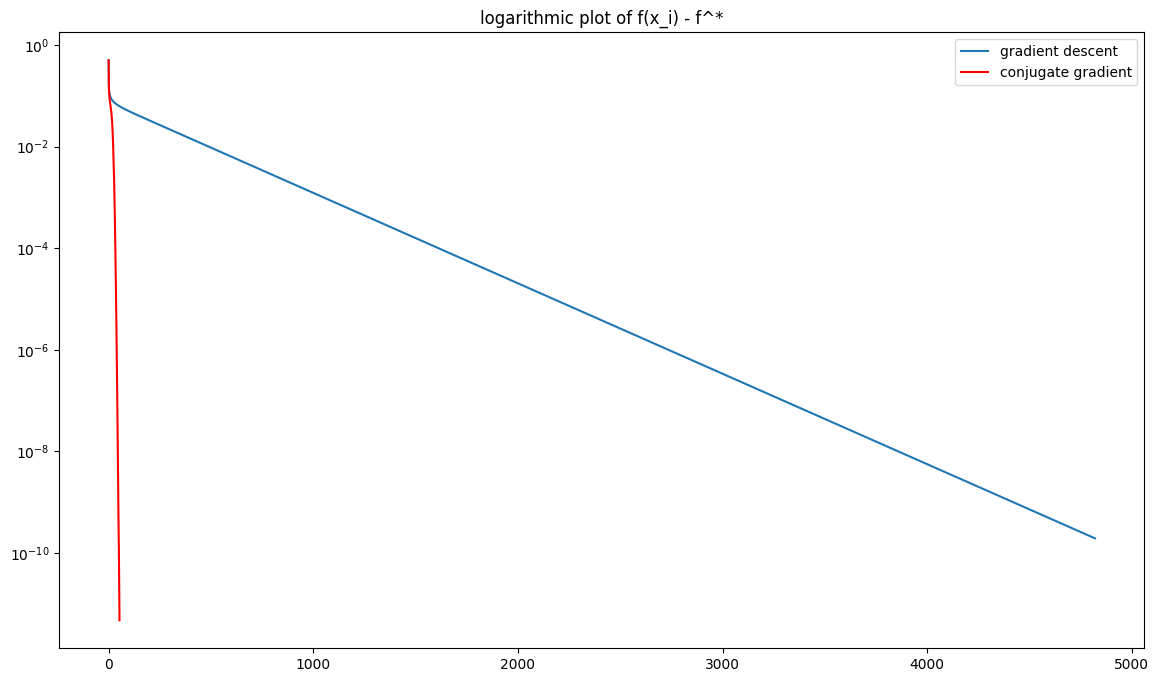

In [41]:
conj_grad_test_3()